# GET SNOW SMELT DATES FOR BEFORE FIRE FOR YEAR OR FIRE AND FALL BEFORE FIRE

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import os
import sys
from datetime import datetime, timedelta
from pathlib import Path
from shapely.geometry import Point
from pykrige.ok import OrdinaryKriging
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.dates as mdates
import rasterio
from rasterio.transform import from_origin
from rasterio.crs import CRS

Read in data

In [2]:
# read in canSWE data
canswe = pd.read_csv('/Users/jgoldman/Library/CloudStorage/GoogleDrive-jandrewgoldman@gmail.com/My Drive/2_SCHOOL/wx/CanSWE-CanEEN_1928-2024_v7.csv')


# read in shield
shield = gpd.read_file('/Users/jgoldman/Library/CloudStorage/GoogleDrive-jandrewgoldman@gmail.com/My Drive/2_SCHOOL/PHD_DATA/OntBSdb/Watersheds_Ecoregion/Ontario_Shield_v0.shp')


inspect data

In [3]:
# print head and all structure of columns 
print("CanSWE data sample:")
print(canswe.head())
print("\nCanSWE data columns:")
print(canswe.columns.tolist())

CanSWE data sample:
    station_id        time        lat     lon  elevation               source  \
0  ALE-05AA805  1965-04-06  49.266666 -114.35     1525.0  Alberta Environment   
1  ALE-05AA805  1968-03-06  49.266666 -114.35     1525.0  Alberta Environment   
2  ALE-05AA805  1968-04-03  49.266666 -114.35     1525.0  Alberta Environment   
3  ALE-05AA805  1969-04-01  49.266666 -114.35     1525.0  Alberta Environment   
4  ALE-05AA805  1970-04-02  49.266666 -114.35     1525.0  Alberta Environment   

       station_name station_name_sec  station_name_ter station_id_sec  \
0  WEST CASTLE SNOW      WEST CASTLE  WEST CASTLE OPEN      SCD-AL219   
1  WEST CASTLE SNOW      WEST CASTLE  WEST CASTLE OPEN      SCD-AL219   
2  WEST CASTLE SNOW      WEST CASTLE  WEST CASTLE OPEN      SCD-AL219   
3  WEST CASTLE SNOW      WEST CASTLE  WEST CASTLE OPEN      SCD-AL219   
4  WEST CASTLE SNOW      WEST CASTLE  WEST CASTLE OPEN      SCD-AL219   

  station_id_ter  type_mes    snw   snd        den dat

check if there is a date column in the dataset


In [4]:
date_columns = [col for col in canswe.columns if 'date' in col.lower() or 'time' in col.lower()]

if date_columns:
    date_col = date_columns[0]
    print(f"\nFound date column: {date_col}")
    
    # Convert to datetime and extract year
    canswe[date_col] = pd.to_datetime(canswe[date_col], errors='coerce')
    canswe['year'] = canswe[date_col].dt.year
    canswe['month'] = canswe[date_col].dt.month

    # rename column id to station_id
    canswe = canswe.rename(columns={'id': 'station_id'})
    
    # Display unique years
    years = canswe['year'].unique()
    years.sort()
    print("\nUnique years in the dataset:")
    print(years)
    
    print(f"\nTotal number of years: {len(years)}")
    print(f"Year range: {min(years)} - {max(years)}")


# print all unique observations in the source column
print("\nUnique observations in the source column:")
print(canswe['source'].unique())


Found date column: time

Unique years in the dataset:
[1928 1929 1930 1931 1932 1933 1934 1935 1936 1937 1938 1939 1940 1941
 1942 1943 1944 1945 1946 1947 1948 1949 1950 1951 1952 1953 1954 1955
 1956 1957 1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969
 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983
 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997
 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011
 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024]

Total number of years: 97
Year range: 1928 - 2024

Unique observations in the source column:
['Alberta Environment' 'British Columbia Environment' 'Churchill Falls'
 'Environment New Brunswick'
 'Crown-Indigenous Relations and Northern Affairs Canada' 'Manitoba Hydro'
 'Ontario Ministry of Natural Resources' 'Ontario Power Generation'
 'Rio Tinto Alcan' 'Meteorological Service of Canada' 'Yukon Territory'
 'Hydro-Quebec' 'Government of Newfoundlan

## 1. Prep Canswe data 

Crop CANSWE data set to shield

make sure to check if latitude and longitude columns exist


In [5]:
if 'lat' in canswe.columns and 'lon' in canswe.columns:
    print("\nChecking which stations are within the Ontario Shield...")
    
    # Initialize in_shield column
    canswe['in_shield'] = False
    
    # More efficient approach: Create GeoDataFrame from all points at once
    # First drop rows with missing lat/lon values
    canswe_with_coords = canswe.dropna(subset=['lat', 'lon'])
    
    # Create point geometries
    geometry = [Point(xy) for xy in zip(canswe_with_coords['lon'], canswe_with_coords['lat'])]
    
    # Create GeoDataFrame
    points_gdf = gpd.GeoDataFrame(canswe_with_coords, geometry=geometry, crs="EPSG:4326")
    
    # Ensure both GeoDataFrames have the same CRS
    if points_gdf.crs != shield.crs:
        points_gdf = points_gdf.to_crs(shield.crs)
    
    # Spatial join to identify points within the shield
    joined = gpd.sjoin(points_gdf, shield, predicate="within", how="left")
    
    # Create a dictionary to map index to in_shield status
    in_shield_dict = {idx: True for idx in joined.index[~joined['index_right'].isna()]}
    
    # Update the original dataframe
    for idx in in_shield_dict:
        canswe.loc[idx, 'in_shield'] = True

    # Print statistics
    shield_count = canswe['in_shield'].sum()
    print(f"\nNumber of stations in the Ontario Shield: {shield_count}")
    print(f"Number of stations not in the Ontario Shield: {len(canswe) - shield_count}")
    
    # Filter to only include stations within the shield
    canswe_shield = canswe[canswe['in_shield'] == True].copy()
    print(f"\nFiltered to {len(canswe_shield)} records from stations within the Ontario Shield")
    
    # Group by station to count observations per station
    station_counts = canswe_shield.groupby('station_id').size().reset_index(name='count')
    print(f"\nNumber of unique stations in the Ontario Shield: {len(station_counts)}")
    print(f"Average observations per station: {station_counts['count'].mean():.1f}")
    
else:
    print("\nLatitude or longitude columns not found in the dataset")
    print("Available columns:", canswe.columns.tolist())




Checking which stations are within the Ontario Shield...

Number of stations in the Ontario Shield: 51295
Number of stations not in the Ontario Shield: 1290385

Filtered to 51295 records from stations within the Ontario Shield

Number of unique stations in the Ontario Shield: 242
Average observations per station: 212.0


filter canswe_shield to only include years 1990-2021

In [6]:

canswe_shield = canswe_shield[(canswe_shield['year'] >= 1990) & (canswe_shield['year'] <= 2021)].copy()
print(f"\nFiltered to {len(canswe_shield)} records from 1990 to 2021")





Filtered to 23564 records from 1990 to 2021


make separate data frame where snd is null or 0


In [7]:
canswe_shield_snd = canswe_shield[(canswe_shield['snd'].isna()) | (canswe_shield['snd'] == 0)].copy()
print(f"\nFiltered to {len(canswe_shield_snd)} records where snd is null or 0")




Filtered to 5870 records where snd is null or 0


print columns in canswe_shield_snd


In [8]:
print("\nColumns in canswe_shield_snd:")
print(canswe_shield_snd.columns.tolist())




Columns in canswe_shield_snd:
['station_id', 'time', 'lat', 'lon', 'elevation', 'source', 'station_name', 'station_name_sec', 'station_name_ter', 'station_id_sec', 'station_id_ter', 'type_mes', 'snw', 'snd', 'den', 'data_flag_snw', 'data_flag_snd', 'qc_flag_snw', 'qc_flag_snd', 'year', 'month', 'in_shield']


For snow melt timing, create a dataframe where the month is less than 6


In [9]:
canswe_shield_snd_melt = canswe_shield_snd[canswe_shield_snd['month'] < 6].copy()
print(f"\nFiltered to {len(canswe_shield_snd_melt)} records where month is less than 6")





Filtered to 4338 records where month is less than 6


find the last day for each station where snd is null or 0


In [10]:
canswe_shield_snd_melt['last_day'] = canswe_shield_snd_melt.groupby('station_id')[date_col].transform('max')
print("\nLast day for each station where snd is null or 0:")
print(canswe_shield_snd_melt[['station_id', 'last_day']].drop_duplicates().head(10))


Last day for each station where snd is null or 0:
      station_id   last_day
74691   ONR-0201 1990-04-15
74995   ONR-0266 1990-05-15
75277   ONR-0294 1990-05-15
76497   ONR-1301 2000-03-01
76710   ONR-1302 2000-03-01
76916   ONR-1303 2000-03-01
77937   ONR-2602 2010-05-15
78377   ONR-2607 1992-05-01
80542   ONR-6008 2010-05-15
80767   ONR-6203 1993-05-01


For snow onset:

1. create dataframe where the month is greater than 9
2. find the first day where snd is greater than 0

In [11]:
canswe_shield_snd_onset = canswe_shield[canswe_shield['snd'] > 0].copy()
print(f"\nFiltered to {len(canswe_shield_snd_onset)} records where snd is greater than 0")



Filtered to 17694 records where snd is greater than 0


In [12]:
canswe_shield_snd_onset = canswe_shield_snd_onset[canswe_shield_snd_onset['month'] >= 9].copy()
print(f"\nFiltered to {len(canswe_shield_snd_onset)} records where month is greater than or equal to 9")




Filtered to 2009 records where month is greater than or equal to 9


In [14]:
canswe_shield_snd_onset['first_day'] = canswe_shield_snd_onset.groupby('station_id')[date_col].transform('min')
print("\nFirst day for each station where snd is null or 0:")
print(canswe_shield_snd_onset[['station_id', 'first_day']].drop_duplicates().head(10))


First day for each station where snd is null or 0:
      station_id  first_day
74698   ONR-0201 1990-12-14
76501   ONR-1301 1990-11-30
76714   ONR-1302 1990-11-30
76922   ONR-1303 1990-12-01
77943   ONR-2602 1990-12-01
78370   ONR-2607 1990-12-10
80533   ONR-6008 1990-12-14
80875   ONR-6401 1992-12-15
80965   ONR-6404 1990-11-15
81023   ONR-6406 1992-12-15


Inspect canswe shield melt and onset data

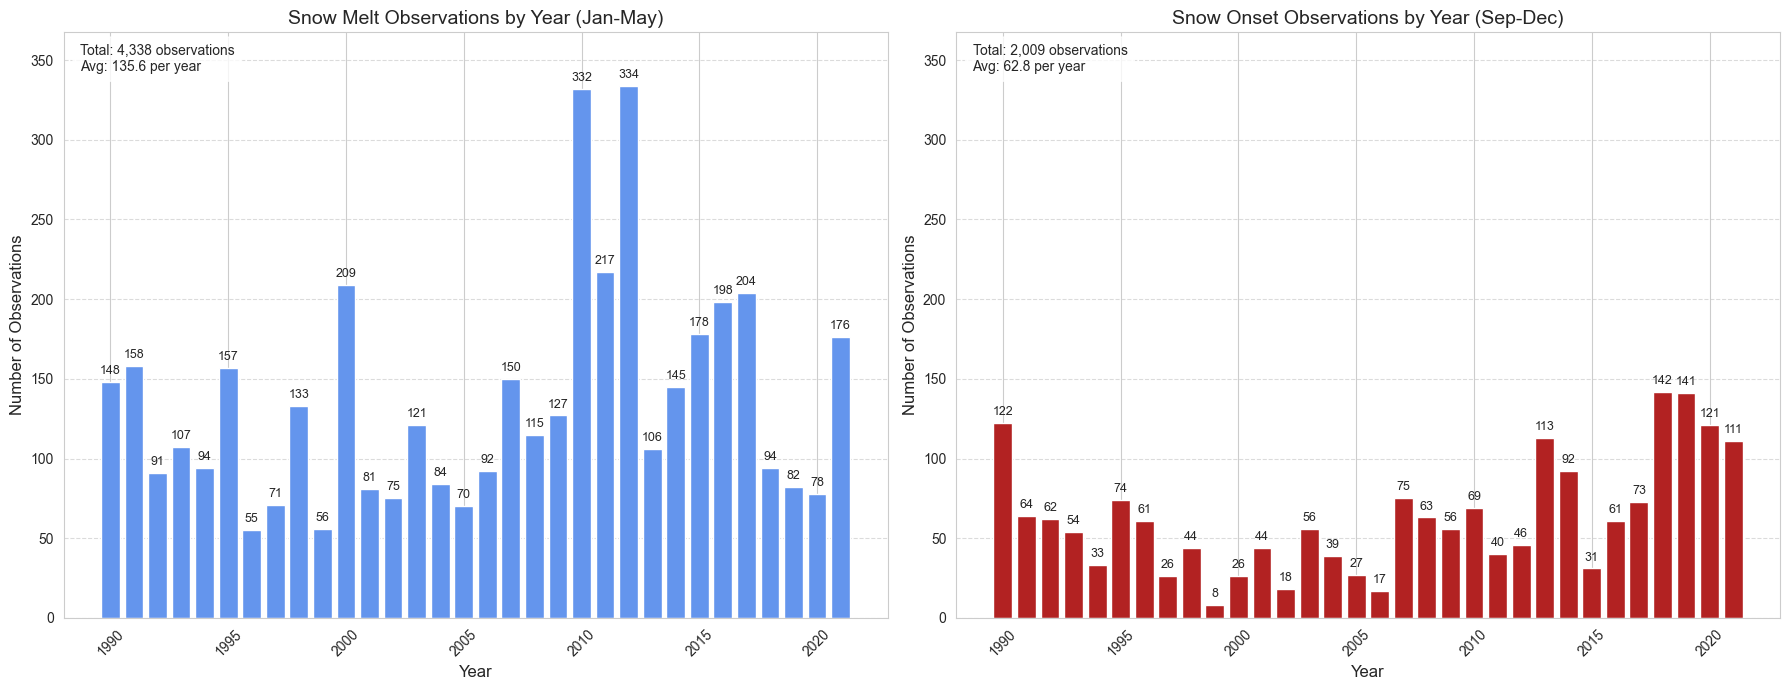

Snow Melt Observations (Jan-May):
Total observations: 4,338
Year with most observations: 2012 (334)
Year with fewest observations: 1996 (55)
Average observations per year: 135.6

Snow Onset Observations (Sep-Dec):
Total observations: 2,009
Year with most observations: 2018 (142)
Year with fewest observations: 1999 (8)
Average observations per year: 62.8


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style
sns.set_style("whitegrid")

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Count observations by year for snow melt
melt_obs_per_year = canswe_shield_snd_melt['year'].value_counts().sort_index()

# Count observations by year for snow onset
onset_obs_per_year = canswe_shield_snd_onset['year'].value_counts().sort_index()

# Plot snow melt observations
ax1.bar(melt_obs_per_year.index, melt_obs_per_year.values, color='cornflowerblue')
ax1.set_title('Snow Melt Observations by Year (Jan-May)', fontsize=14)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Number of Observations', fontsize=12)
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.tick_params(axis='x', rotation=45)

# Add data labels on top of each bar for melt observations
for i, v in enumerate(melt_obs_per_year):
    ax1.text(melt_obs_per_year.index[i], v + 5, str(v), 
            ha='center', fontsize=9)

# Add statistics to the top left corner of first plot
melt_stats_text = (f"Total: {melt_obs_per_year.sum():,} observations\n"
                  f"Avg: {melt_obs_per_year.mean():.1f} per year")
ax1.text(0.02, 0.98, melt_stats_text, 
        transform=ax1.transAxes, 
        fontsize=10, 
        verticalalignment='top', 
        bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))

# Plot snow onset observations
ax2.bar(onset_obs_per_year.index, onset_obs_per_year.values, color='firebrick')
ax2.set_title('Snow Onset Observations by Year (Sep-Dec)', fontsize=14)
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylabel('Number of Observations', fontsize=12)
ax2.grid(axis='y', linestyle='--', alpha=0.7)
ax2.tick_params(axis='x', rotation=45)

# Add data labels on top of each bar for onset observations
for i, v in enumerate(onset_obs_per_year):
    ax2.text(onset_obs_per_year.index[i], v + 5, str(v), 
            ha='center', fontsize=9)

# Add statistics to the top left corner of second plot
onset_stats_text = (f"Total: {onset_obs_per_year.sum():,} observations\n"
                   f"Avg: {onset_obs_per_year.mean():.1f} per year")
ax2.text(0.02, 0.98, onset_stats_text, 
        transform=ax2.transAxes, 
        fontsize=10, 
        verticalalignment='top', 
        bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))

# Adjust y-axis limits to be the same for both plots
max_obs = max(melt_obs_per_year.max(), onset_obs_per_year.max())
ax1.set_ylim(0, max_obs * 1.1)  # Add 10% padding
ax2.set_ylim(0, max_obs * 1.1)

# Adjust layout
plt.tight_layout()
plt.show()

# Print additional statistics
print(f"Snow Melt Observations (Jan-May):")
print(f"Total observations: {melt_obs_per_year.sum():,}")
print(f"Year with most observations: {melt_obs_per_year.idxmax()} ({melt_obs_per_year.max():,})")
print(f"Year with fewest observations: {melt_obs_per_year.idxmin()} ({melt_obs_per_year.min():,})")
print(f"Average observations per year: {melt_obs_per_year.mean():.1f}")

print(f"\nSnow Onset Observations (Sep-Dec):")
print(f"Total observations: {onset_obs_per_year.sum():,}")
print(f"Year with most observations: {onset_obs_per_year.idxmax()} ({onset_obs_per_year.max():,})")
print(f"Year with fewest observations: {onset_obs_per_year.idxmin()} ({onset_obs_per_year.min():,})")
print(f"Average observations per year: {onset_obs_per_year.mean():.1f}")

## 2. Find the first instance where 3 consecutive days where snd is null or 0 and return the date as the snow_melt_date


Function to find consecutive days for snow melt

In [16]:
def find_consecutive_snow_free_days(df, station_id, year, date_column, min_consecutive_days=3):
    """
    Find the first occurrence of min_consecutive_days consecutive days where snd is null or 0 
    for a station in a specific year
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing the snow data
    station_id : str or int
        ID of the station to analyze
    year : int
        Year to analyze
    date_column : str
        Name of the column containing dates
    min_consecutive_days : int, optional (default=3)
        Minimum number of consecutive days required
        
    Returns:
    --------
    datetime or None
        The date of the first day of the first occurrence of min_consecutive_days 
        consecutive days where snd is null or 0, or None if no such sequence exists
    """
    # Filter data for the specific station and year, and sort by date
    station_data = df[(df['station_id'] == station_id) & (df['year'] == year)].sort_values(by=date_column)
    
    if len(station_data) == 0:
        return None
    
    # If the station has fewer records than min_consecutive_days, use what's available if >= 1
    if 0 < len(station_data) < min_consecutive_days:
        return station_data[date_column].min()
    
    # Check data point spacing - if sparse data, relax the consecutive day requirement
    date_diffs = station_data[date_column].diff().dropna()
    avg_interval = date_diffs.mean().days
    
    # For sparse data (average interval > 3 days), use the first zero/null SND record
    if avg_interval > 3:
        return station_data[date_column].min()
    
    # For data with good temporal coverage, check for consecutive days
    # Get all dates for this station-year
    dates = station_data[date_column].tolist()
    
    # Track consecutive days
    streak_start = None
    streak_length = 1
    
    for i in range(1, len(dates)):
        prev_date = dates[i-1]
        curr_date = dates[i]
        
        # Check if dates are consecutive or close (within 2 days)
        if (curr_date - prev_date).days <= 2:
            if streak_start is None:
                streak_start = prev_date
            streak_length += 1
            if streak_length >= min_consecutive_days:
                return streak_start
        else:
            # Reset streak
            streak_start = None
            streak_length = 1
    
    # If we didn't find consecutive days but have data, return the first date
    if len(station_data) > 0:
        return station_data[date_column].min()
    
    return None





In [17]:
# Get list of unique stations
unique_stations = canswe_shield_snd['station_id'].unique()
print(f"\nFound {len(unique_stations)} unique stations for snow melt analysis")

# Get list of unique years for analysis (focus on spring months for actual melt)
spring_data = canswe_shield_snd[(canswe_shield_snd['month'] >= 1) & (canswe_shield_snd['month'] <= 5)]
unique_years = spring_data['year'].unique()
unique_years.sort()
print(f"Analyzing data for years: {', '.join(map(str, unique_years))}")



Found 145 unique stations for snow melt analysis
Analyzing data for years: 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021


In [18]:
# Create a list to store results
snow_melt_data = []

# Process each station and year combination
for station in unique_stations:
    for year in unique_years:
        melt_date = find_consecutive_snow_free_days(
            spring_data,  # Using the SND=0 filtered dataset, spring months only
            station, 
            year,
            date_col
        )
        if melt_date is not None:
            snow_melt_data.append({
                'station_id': station,
                'year': year,
                'snow_melt_date': melt_date,
                'month': melt_date.month,
                'day': melt_date.day
            })

# Create DataFrame from results
snow_melt_df = pd.DataFrame(snow_melt_data)


In [19]:
# Display results
print(f"\nIdentified {len(snow_melt_df)} snow melt dates across stations and years")
if not snow_melt_df.empty:
    print("\nSample of snow melt dates:")
    print(snow_melt_df.head(10))
    
    # Count records per year
    year_counts = snow_melt_df['year'].value_counts().sort_index()
    print("\nSnow melt date counts by year:")
    print(year_counts)
    
    # Basic statistics on snow melt dates
    snow_melt_df['doy'] = snow_melt_df['snow_melt_date'].dt.dayofyear
    print("\nStatistics on day of year for snow melt dates:")
    print(snow_melt_df['doy'].describe())
    
    # Count by month
    month_counts = snow_melt_df['month'].value_counts().sort_index()
    print("\nSnow melt date counts by month:")
    for month, count in month_counts.items():
        month_name = datetime(2000, month, 1).strftime('%B')
        print(f"{month_name}: {count}")
    
    # Average snow melt date by year
    annual_avg = snow_melt_df.groupby('year')['doy'].mean().reset_index()
    print("\nAverage snow melt day of year by year:")
    print(annual_avg)
    
    # Save to CSV, but check if file already exists first
    output_file = os.path.expanduser("~/Work/PhD/time-lagged-moisture-project/data/ont_shield_snow_melt_dates_1990_2021.csv")
    if os.path.exists(output_file):
        print(f"\nFile already exists: {output_file}")
        print("Not overwriting existing file.")
    else:
        snow_melt_df.to_csv(output_file, index=False)
        print(f"\nSaved snow melt dates to: {output_file}")
else:
    print("No snow melt dates identified. Check your data and criteria.")



Identified 2138 snow melt dates across stations and years

Sample of snow melt dates:
  station_id  year snow_melt_date  month  day
0   ONR-0201  1990     1990-03-15      3   15
1   ONR-0266  1990     1990-05-01      5    1
2   ONR-0294  1990     1990-05-01      5    1
3   ONR-1301  1990     1990-04-02      4    2
4   ONR-1301  1991     1991-04-02      4    2
5   ONR-1301  1993     1993-04-15      4   15
6   ONR-1301  1994     1994-04-15      4   15
7   ONR-1301  1995     1995-03-15      3   15
8   ONR-1301  2000     2000-03-01      3    1
9   ONR-1302  1990     1990-04-02      4    2

Snow melt date counts by year:
1990    61
1991    80
1992    70
1993    60
1994    61
1995    71
1996    41
1997    60
1998    57
1999    42
2000    71
2001    43
2002    52
2003    65
2004    62
2005    49
2006    66
2007    80
2008    81
2009    68
2010    87
2011    83
2012    88
2013    56
2014    75
2015    92
2016    81
2017    85
2018    64
2019    61
2020    45
2021    81
Name: year, dtype: int6

In [20]:
# for each station, find the first observation for each year from canswe_shield 
canswe_shield_first_obs = canswe_shield.groupby(['station_id', 'year']).agg({
    date_col: 'min',
    'snd': 'min'
}).reset_index()
print(f"\nFound {len(canswe_shield_first_obs)} first observations for each station and year")
# print the values for the station ids in the  sample of snow melt dates above
print("\nSample of first observations for each station and year:")
print(canswe_shield_first_obs[canswe_shield_first_obs['station_id'].isin(snow_melt_df['station_id'])].head(10))



Found 2787 first observations for each station and year

Sample of first observations for each station and year:
   station_id  year       time    snd
1    ONR-0201  1990 1990-01-02  0.000
2    ONR-0201  1991 1991-12-16  0.020
3    ONR-0201  1992 1992-03-02  0.011
4    ONR-0201  1993 1993-02-15  0.000
5    ONR-0201  1994 1994-03-15  0.190
6    ONR-0201  1995 1995-02-15  0.030
7    ONR-0201  1996 1996-03-01  0.150
8    ONR-0201  1997 1997-02-14  0.000
9    ONR-0266  1990 1990-02-01  0.000
10   ONR-0294  1990 1990-02-01  0.000


Inspect snow melt df

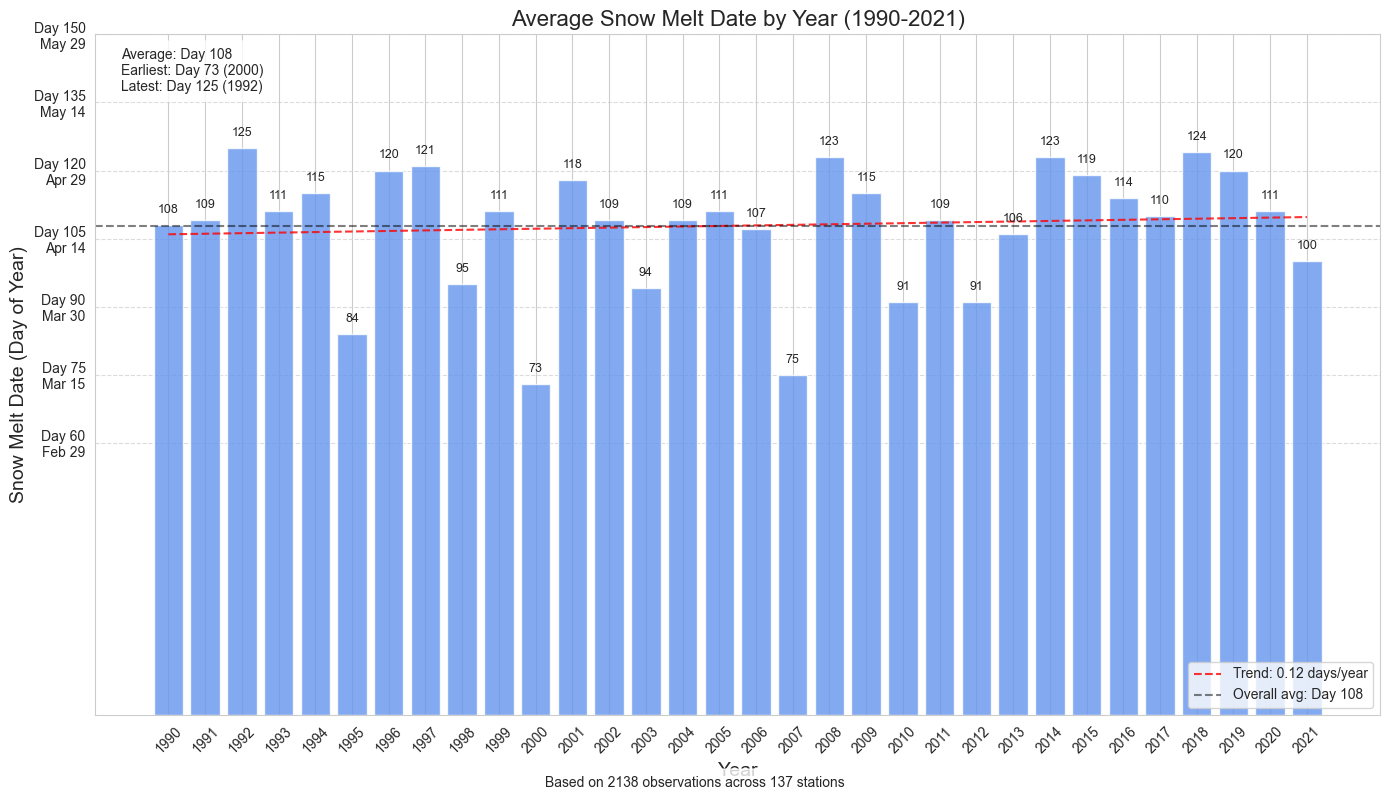


Average snow melt day of year by year (rounded):
    year  doy
0   1990  108
1   1991  109
2   1992  125
3   1993  111
4   1994  115
5   1995   84
6   1996  120
7   1997  121
8   1998   95
9   1999  111
10  2000   73
11  2001  118
12  2002  109
13  2003   94
14  2004  109
15  2005  111
16  2006  107
17  2007   75
18  2008  123
19  2009  115
20  2010   91
21  2011  109
22  2012   91
23  2013  106
24  2014  123
25  2015  119
26  2016  114
27  2017  110
28  2018  124
29  2019  120
30  2020  111
31  2021  100

Trend: 0.12 days/year
Overall average: Day 108


In [23]:
# Calculate the average snow melt day of year by year (with rounding to integer)
annual_avg_melt = snow_melt_df.groupby('year')['doy'].mean().round().astype(int).reset_index()

# Set the style
sns.set_style("whitegrid")
plt.figure(figsize=(14, 8))

# Create bar chart for average snow melt day of year
bars = plt.bar(annual_avg_melt['year'], annual_avg_melt['doy'], color='cornflowerblue', alpha=0.8)

# Add a trend line
z = np.polyfit(annual_avg_melt['year'], annual_avg_melt['doy'], 1)
p = np.poly1d(z)
plt.plot(annual_avg_melt['year'], p(annual_avg_melt['year']), "r--", alpha=0.8, 
         label=f"Trend: {z[0]:.2f} days/year")

# Calculate overall average
overall_avg = annual_avg_melt['doy'].mean()
plt.axhline(y=overall_avg, color='k', linestyle='--', alpha=0.5, 
            label=f"Overall avg: Day {overall_avg:.0f}")

# Add data labels on top of each bar
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 2,
             f"{height}", ha='center', va='bottom', fontsize=9)

# Add reference dates to y-axis (convert some DOYs to dates)
y_ticks = np.arange(60, 151, 15)  # Adjust range as needed based on your data
y_tick_labels = []
for doy in y_ticks:
    date = pd.Timestamp(f"2020-01-01") + pd.Timedelta(days=doy-1)
    y_tick_labels.append(f"Day {doy}\n{date.strftime('%b %d')}")
    
plt.yticks(y_ticks, y_tick_labels)

# Add labels and title
plt.xlabel('Year', fontsize=14)
plt.ylabel('Snow Melt Date (Day of Year)', fontsize=14)
plt.title('Average Snow Melt Date by Year (1990-2021)', fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(annual_avg_melt['year'], rotation=45)

# Add statistics to the top left corner
stats_text = (f"Average: Day {overall_avg:.0f}\n"
              f"Earliest: Day {annual_avg_melt['doy'].min()} ({annual_avg_melt.loc[annual_avg_melt['doy'].idxmin(), 'year']})\n"
              f"Latest: Day {annual_avg_melt['doy'].max()} ({annual_avg_melt.loc[annual_avg_melt['doy'].idxmax(), 'year']})")
plt.text(0.02, 0.98, stats_text, 
        transform=plt.gca().transAxes, 
        fontsize=10, 
        verticalalignment='top', 
        bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))

# Add legend
plt.legend(loc='lower right')

# Adjust layout
plt.tight_layout()

# Count observations per year for reference
year_counts = snow_melt_df['year'].value_counts().sort_index()
counts_text = f"Based on {len(snow_melt_df)} observations across {len(snow_melt_df['station_id'].unique())} stations"
plt.figtext(0.5, 0.01, counts_text, ha='center', fontsize=10, 
            bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))

# Show the plot
plt.show()

# Print summary statistics for reference
print("\nAverage snow melt day of year by year (rounded):")
print(annual_avg_melt)
print(f"\nTrend: {z[0]:.2f} days/year")
print(f"Overall average: Day {overall_avg:.0f}")

## 3. Find the first instance where 3 consecutive days where snd is greater tha 0 and return the date as the snow_onset_date


In [24]:
def find_consecutive_snow_days(df, station_id, year, date_column, min_consecutive_days=3):
    """
    Find the first occurrence of min_consecutive_days consecutive days where snd is greater than 0
    for a station in a specific year
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing the snow data
    station_id : str or int
        ID of the station to analyze
    year : int
        Year to analyze
    date_column : str
        Name of the column containing dates
    min_consecutive_days : int, optional (default=3)
        Minimum number of consecutive days required
        
    Returns:
    --------
    datetime or None
        The date of the first day of the first occurrence of min_consecutive_days 
        consecutive days where snd > 0, or None if no such sequence exists
    """
    # Filter data for the specific station and year, and sort by date
    station_data = df[(df['station_id'] == station_id) & (df['year'] == year)].sort_values(by=date_column)
    
    if len(station_data) == 0:
        return None
    
    # If the station has fewer records than min_consecutive_days, use what's available if >= 1
    if 0 < len(station_data) < min_consecutive_days:
        return station_data[date_column].min()
    
    # Check data point spacing - if sparse data, relax the consecutive day requirement
    date_diffs = station_data[date_column].diff().dropna()
    if len(date_diffs) > 0:  # Check if we have enough data to calculate mean
        avg_interval = date_diffs.mean().days
        
        # For sparse data (average interval > 3 days), use the first SND > 0 record
        if avg_interval > 3:
            return station_data[date_column].min()
    
    # For data with good temporal coverage, check for consecutive days
    # Get all dates for this station-year
    dates = station_data[date_column].tolist()
    
    # Track consecutive days
    streak_start = None
    streak_length = 1
    
    for i in range(1, len(dates)):
        prev_date = dates[i-1]
        curr_date = dates[i]
        
        # Check if dates are consecutive or close (within 2 days)
        if (curr_date - prev_date).days <= 2:
            if streak_start is None:
                streak_start = prev_date
            streak_length += 1
            if streak_length >= min_consecutive_days:
                return streak_start
        else:
            # Reset streak
            streak_start = None
            streak_length = 1
    
    # If we didn't find consecutive days but have data, return the first date
    if len(station_data) > 0:
        return station_data[date_column].min()
    
    return None





In [25]:
# Get list of unique stations for snow onset analysis
unique_stations_onset = canswe_shield_snd_onset['station_id'].unique()
print(f"\nFound {len(unique_stations_onset)} unique stations for snow onset analysis")

# Get list of unique years for analysis (focus on fall months for onset)
fall_data = canswe_shield_snd_onset  # Already filtered for month >= 9 and snd > 0
unique_years_onset = fall_data['year'].unique()
unique_years_onset.sort()
print(f"Analyzing data for years: {', '.join(map(str, unique_years_onset))}")

# Create a list to store results
snow_onset_data = []

# Process each station and year combination
for station in unique_stations_onset:
    for year in unique_years_onset:
        onset_date = find_consecutive_snow_days(
            fall_data,  # Using the filtered dataset for SND > 0 in fall months
            station, 
            year,
            date_col
        )
        if onset_date is not None:
            snow_onset_data.append({
                'station_id': station,
                'year': year,
                'snow_onset_date': onset_date,
                'month': onset_date.month,
                'day': onset_date.day
            })

# Create DataFrame from results
snow_onset_df = pd.DataFrame(snow_onset_data)


Found 89 unique stations for snow onset analysis
Analyzing data for years: 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021


In [26]:
# Display results
print(f"\nIdentified {len(snow_onset_df)} snow onset dates across stations and years")
if not snow_onset_df.empty:
    print("\nSample of snow onset dates:")
    print(snow_onset_df.head(10))
    
    # Calculate day of year for easier analysis
    snow_onset_df['doy'] = snow_onset_df['snow_onset_date'].dt.dayofyear
    
    # Count records per year
    year_counts = snow_onset_df['year'].value_counts().sort_index()
    print("\nSnow onset date counts by year:")
    print(year_counts)
    
    # Basic statistics on snow onset dates
    print("\nStatistics on day of year for snow onset dates:")
    print(snow_onset_df['doy'].describe())
    
    # Count by month
    month_counts = snow_onset_df['month'].value_counts().sort_index()
    print("\nSnow onset date counts by month:")
    for month, count in month_counts.items():
        month_name = datetime(2000, month, 1).strftime('%B')
        print(f"{month_name}: {count}")
    
    # Average snow onset date by year
    annual_avg = snow_onset_df.groupby('year')['doy'].mean().reset_index()
    print("\nAverage snow onset day of year by year:")
    print(annual_avg)
    
    # Save to CSV, but check if file already exists first
    output_file = os.path.expanduser("~/Work/PhD/time-lagged-moisture-project/data/ont_shield_snow_onset_dates_1990_2021.csv")
    if os.path.exists(output_file):
        print(f"\nFile already exists: {output_file}")
        print("Not overwriting existing file.")
    else:
        snow_onset_df.to_csv(output_file, index=False)
        print(f"\nSaved snow onset dates to: {output_file}")
else:
    print("No snow onset dates identified. Check your data and criteria.")


Identified 1052 snow onset dates across stations and years

Sample of snow onset dates:
  station_id  year snow_onset_date  month  day
0   ONR-0201  1990      1990-12-14     12   14
1   ONR-0201  1991      1991-12-16     12   16
2   ONR-0201  1992      1992-12-16     12   16
3   ONR-0201  1994      1994-12-30     12   30
4   ONR-0201  1995      1995-12-01     12    1
5   ONR-0201  1996      1996-11-30     11   30
6   ONR-1301  1990      1990-11-30     11   30
7   ONR-1301  1991      1991-12-14     12   14
8   ONR-1301  1992      1992-12-16     12   16
9   ONR-1301  1993      1993-12-16     12   16

Snow onset date counts by year:
1990    41
1991    37
1992    37
1993    37
1994    17
1995    35
1996    30
1997    14
1998    28
1999     3
2000    19
2001    31
2002    16
2003    27
2004    26
2005    19
2006    11
2007    40
2008    30
2009    37
2010    43
2011    24
2012    27
2013    52
2014    47
2015    20
2016    45
2017    43
2018    52
2019    55
2020    53
2021    56
Name: yea

inspect snow onset data

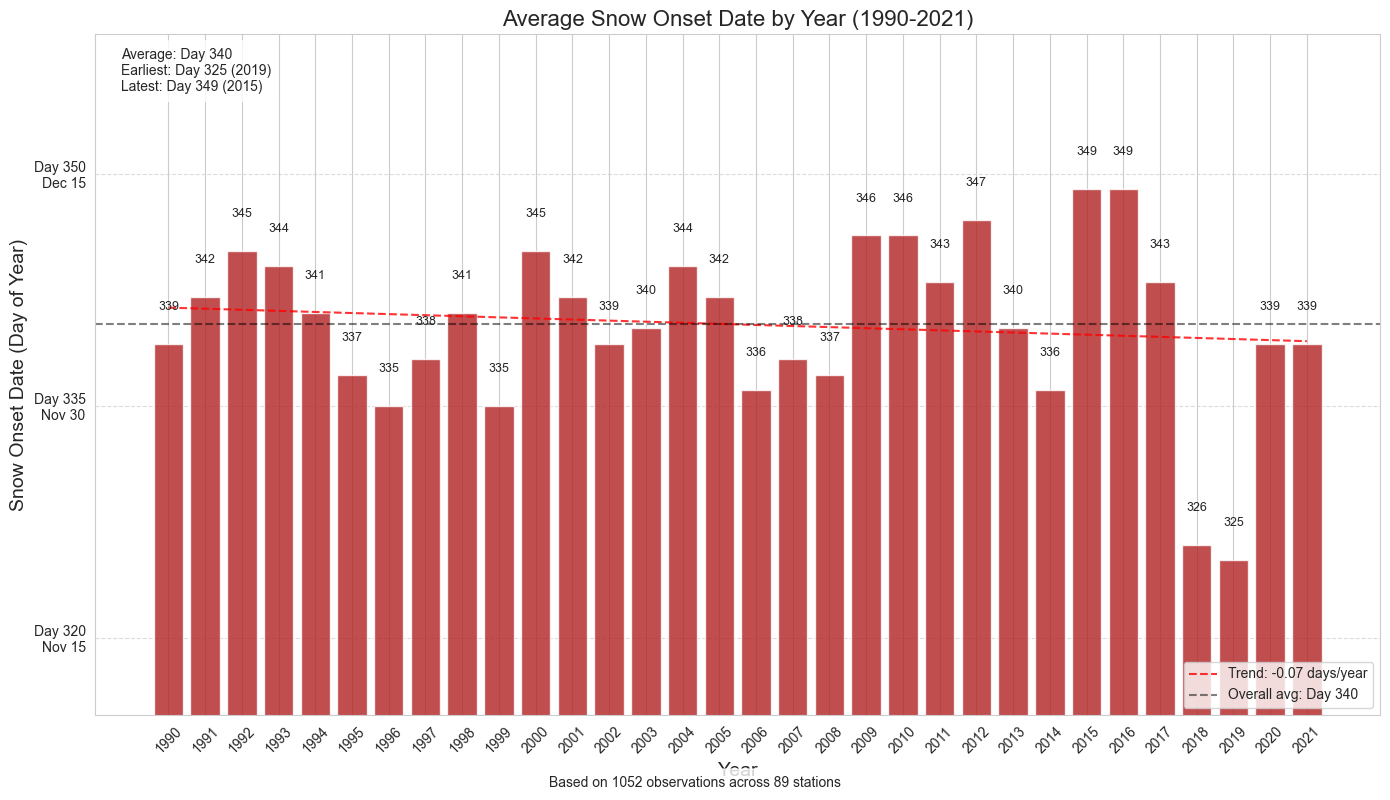


Average snow onset day of year by year (rounded):
    year  doy
0   1990  339
1   1991  342
2   1992  345
3   1993  344
4   1994  341
5   1995  337
6   1996  335
7   1997  338
8   1998  341
9   1999  335
10  2000  345
11  2001  342
12  2002  339
13  2003  340
14  2004  344
15  2005  342
16  2006  336
17  2007  338
18  2008  337
19  2009  346
20  2010  346
21  2011  343
22  2012  347
23  2013  340
24  2014  336
25  2015  349
26  2016  349
27  2017  343
28  2018  326
29  2019  325
30  2020  339
31  2021  339

Trend: -0.07 days/year
Overall average: Day 340


In [30]:
# Calculate the average snow onset day of year by year (with rounding to integer)
annual_avg_onset = snow_onset_df.groupby('year')['doy'].mean().round().astype(int).reset_index()

# Set the style
sns.set_style("whitegrid")
plt.figure(figsize=(14, 8))

# Calculate Sept 1 DOY for reference (but we'll use actual DOYs in the plot)
sept1_doy = 245  # DOY for Sept 1 in 2020 (leap year)

# Create bar chart for average snow onset day of year - using actual DOY values
bars = plt.bar(annual_avg_onset['year'], annual_avg_onset['doy'], color='firebrick', alpha=0.8)

# Add a trend line with actual DOY values
z = np.polyfit(annual_avg_onset['year'], annual_avg_onset['doy'], 1)
p = np.poly1d(z)
plt.plot(annual_avg_onset['year'], p(annual_avg_onset['year']), "r--", alpha=0.8, 
         label=f"Trend: {z[0]:.2f} days/year")

# Calculate overall average
overall_avg = annual_avg_onset['doy'].mean()
plt.axhline(y=overall_avg, color='k', linestyle='--', alpha=0.5, 
            label=f"Overall avg: Day {overall_avg:.0f}")

# Add data labels on top of each bar - showing actual DOY values
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 2,
             f"{height}", ha='center', va='bottom', fontsize=9)

# Add reference dates to y-axis using actual DOY values for fall dates
# Create a sequence from Sept 1 to Dec 31 with 15-day steps
y_ticks = np.arange(sept1_doy, 366, 15)  # Start from Sept 1 DOY, go to end of year
y_tick_labels = []
for doy in y_ticks:
    date = pd.Timestamp(f"2020-01-01") + pd.Timedelta(days=doy-1)
    y_tick_labels.append(f"Day {doy}\n{date.strftime('%b %d')}")
    
plt.yticks(y_ticks, y_tick_labels)

# Set y-axis limits to focus on the relevant range
y_min = max(240, annual_avg_onset['doy'].min() - 10)  # Start slightly before Sept 1
y_max = min(366, annual_avg_onset['doy'].max() + 10)  # End at or before Dec 31
plt.ylim(y_min, y_max)

# Add labels and title
plt.xlabel('Year', fontsize=14)
plt.ylabel('Snow Onset Date (Day of Year)', fontsize=14)
plt.title('Average Snow Onset Date by Year (1990-2021)', fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(annual_avg_onset['year'], rotation=45)

# Add statistics to the top left corner - with actual DOY values
stats_text = (f"Average: Day {overall_avg:.0f}\n"
              f"Earliest: Day {annual_avg_onset['doy'].min()} ({annual_avg_onset.loc[annual_avg_onset['doy'].idxmin(), 'year']})\n"
              f"Latest: Day {annual_avg_onset['doy'].max()} ({annual_avg_onset.loc[annual_avg_onset['doy'].idxmax(), 'year']})")
plt.text(0.02, 0.98, stats_text, 
        transform=plt.gca().transAxes, 
        fontsize=10, 
        verticalalignment='top', 
        bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))

# Add legend
plt.legend(loc='lower right')

# Adjust layout
plt.tight_layout()

# Count observations per year for reference
year_counts = snow_onset_df['year'].value_counts().sort_index()
counts_text = f"Based on {len(snow_onset_df)} observations across {len(snow_onset_df['station_id'].unique())} stations"
plt.figtext(0.5, 0.01, counts_text, ha='center', fontsize=10, 
            bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))

# Show the plot
plt.show()

# Print summary statistics for reference
print("\nAverage snow onset day of year by year (rounded):")
print(annual_avg_onset[['year', 'doy']])
print(f"\nTrend: {z[0]:.2f} days/year")
print(f"Overall average: Day {overall_avg:.0f}")